# Tweets dos possíveis candidatos a presidência em 2022
## Neste estudo queremos determinar qual é a relação entre os possíveis candidatos a presidência para 2022 atraves dos seus tweets publicados. Vamos fazer uma análise destes tweets e treinar um modelo que irá predizer a qual candidato determinado texto pertence.

# Bibliotecas Utilizadas e inicialização

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import spacy
import regex as re
from collections import Counter
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords


nlp = spacy.load("pt_core_news_md")


# Funções Diversas

In [3]:
# Function to remove emoji.
def emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [39]:
def tokenize(texto):
    doc = nlp.tokenizer(texto)
    return [token.lower_ for token in doc if not (token.is_punct | token.is_stop)]

In [38]:
doc = nlp(df_politicos[df_politicos['nome'] == 'Amoedo']['text'][2])
print(doc)
print([token.is_punct for token in doc])

O governo federal e o Congresso ignoraram no Orçamento de 2021 a nova onda do coronavírus. A falta de planejamento levou a atrasos no:

-Auxílio Emergencial
-Programa de manutenção do emprego
-Pronampe

O brasileiro paga a conta com a fome, o desemprego e falências.
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, True]


In [40]:
def unnest_tokens(df, # Data Frame (em linhas)
                  coluna_tokenize, # nome da coluna com os textos (tweets)
                  coluna_token_nome='palavra', # nome da coluna com os tokens
                  tokenizer_function=tokenize): # what tokenizer to use
    
    return (df[coluna_tokenize]
              .apply(tokenizer_function)
              .apply(pd.Series)
              .stack()
              .reset_index(level=0)
              .set_index('level_0')
              .rename(columns={0: coluna_token_nome})
              .join(df.drop(coluna_tokenize, 1), how='left')
              .reset_index(drop=True))

In [52]:
def retirando_palavras_indesejadas(df, coluna_token="palavra"):
    stop_words_ingles = set(stopwords.words('english'))
    stop_words_espanhol = set(stopwords.words('spanish'))
    symbols = set(['-', 'r$', 'R$', '|', ' ', 'ser', 'vai', 'pra', 'q', 'p', 'tb', 'vou', 'ter'])
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    df = df[~ df[coluna_token].isin(stop_words_ingles | stop_words_espanhol | symbols)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if re.match(r'http*', w) != None)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if emoji_pattern.match(w) != None)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if (w.startswith('@') | w.startswith('#') | w.startswith('\r')))]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if w == 'rt')]
    return df

# Carregando os dados 

Os dados foram conseguidos via a API.V2 do tweeter diretamente do Banco de Dados do tweeter. Utilizamos a versão 2 desta API que permite um máximo de 3200 tweets por conta. Portanto a nossa análise vai estar limitada a este número máximo de mensagens o que em alguns casos cobre todos os tweets do político e em outras apenas o último ano.

Utilizamos esta API através do site WORKBENCH - https://app.workbenchdata.com/workflows/142512/

In [7]:
# Dataframe com todos os politicos e seus tweets
lista_dir = os.listdir("./politicos/")
nome_politicos = []
df_politicos = pd.DataFrame()
for nome in lista_dir:
    df_politico = pd.read_csv(
        f"./politicos/{nome}",
        delimiter=",",
        encoding='utf-8',
        usecols=[1,2,8]
    )
    df_politico['nome'] = nome[:-4]
    nome_politicos.append(nome[:-4])
    df_politicos = df_politicos.append(df_politico)
cols = ['nome'] + [col for col in df_politicos if col != 'nome']
df_politicos = df_politicos[cols]
df_politicos.reset_index(inplace=True)

In [9]:
df_politicos.head(10)

index    nome            created_at  \
0      0  Amoedo  2021-04-19T16:18:20Z   
1      1  Amoedo  2021-04-19T16:05:53Z   
2      2  Amoedo  2021-04-19T15:32:40Z   
3      3  Amoedo  2021-04-19T12:53:14Z   
4      4  Amoedo  2021-04-19T12:25:58Z   
5      5  Amoedo  2021-04-19T12:19:42Z   
6      6  Amoedo  2021-04-18T19:21:07Z   
7      7  Amoedo  2021-04-18T19:21:06Z   
8      8  Amoedo  2021-04-18T15:42:35Z   
9      9  Amoedo  2021-04-18T15:42:25Z   

                                                text                   id  
0  RT @MBLivre: Presidente americano Joe Biden an...  1384179569712713735  
1  Temos que fazer a nossa parte. Não podemos dei...  1384176435552608259  
2  O governo federal e o Congresso ignoraram no O...  1384168077697314825  
3  RT @o_antagonista: .@joaoamoedonovo sugeriu no...  1384127951311040517  
4                     Informações de @OGloboPolitica  1384121090243383296  
5  A CPI da Pandemia no Senado deve investigar o ...  1384119514418216969  
6  Leia a coluna completa em https://t.co/rvNDUpnqgA  1383863178853969921  
7  "Membros do Executivo e do Legislativo não ace...  1383863176891015168  
8                       Informações de @RevistaEpoca  1383808183223734272  
9  O governo federal gastará R$500 mil em uma cam...  1383808141897342986

In [10]:
df_politicos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31633 entries, 0 to 31632
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       31633 non-null  int64 
 1   nome        31633 non-null  object
 2   created_at  31633 non-null  object
 3   text        31633 non-null  object
 4   id          31633 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.2+ MB


# WordClouds e outras análises

In [53]:
# criando dataframe apenas com as palavras e os politicos e o índice original para o tweet.
# já estamos retirando pontuações e STOP WORDS da lingua portuguesa.
#df_palavras = unnest_tokens(df_politicos.drop(['index','created_at','id'], axis=1), 'text')
df_palavras = unnest_tokens(df_politicos.drop(['created_at','id'], axis=1), 'text')

In [54]:
df_palavras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512565 entries, 0 to 512564
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   palavra  512565 non-null  object
 1   index    512565 non-null  int64 
 2   nome     512565 non-null  object
dtypes: int64(1), object(2)
memory usage: 11.7+ MB


In [56]:
df_palavras = retirando_palavras_indesejadas(df_palavras)

In [58]:
df_palavras.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428960 entries, 2 to 512564
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   palavra  428960 non-null  object
 1   index    428960 non-null  int64 
 2   nome     428960 non-null  object
dtypes: int64(1), object(2)
memory usage: 13.1+ MB


In [60]:
df_palavras.head(10)

palavra  index    nome
2   presidente      0  Amoedo
3    americano      0  Amoedo
4          joe      0  Amoedo
5        biden      0  Amoedo
6      anuncia      0  Amoedo
7         hoje      0  Amoedo
8       vacina      0  Amoedo
9   disponível      0  Amoedo
10  americanos      0  Amoedo
12     podemos      1  Amoedo

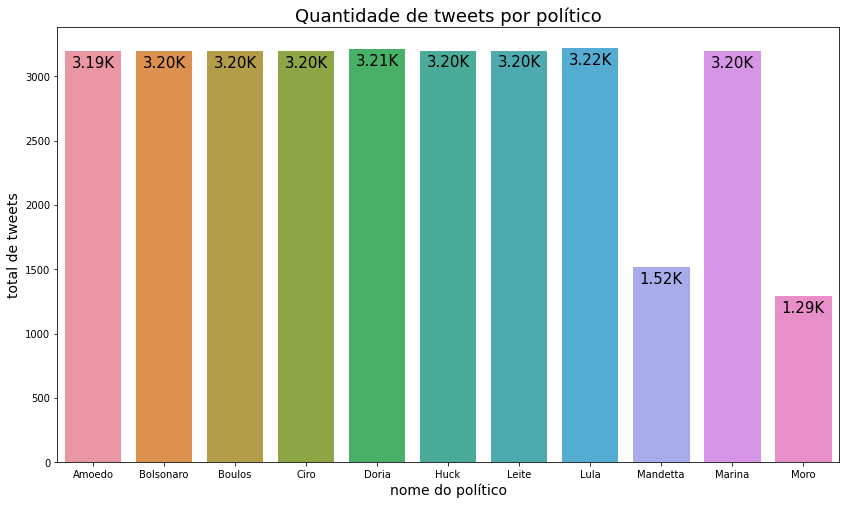

In [62]:
#quantidade de tweets por político

df_plot = df_politicos.groupby('nome').agg(total =('text','count'))
df_plot.reset_index(inplace=True)

plt.figure(figsize=(14, 8))
splot=sns.barplot(x="nome", y="total", data=df_plot)
plt.xlabel("nome do político", size=14)
plt.ylabel("total de tweets", size=14)
plt.title("Quantidade de tweets por político", size=18)
for p in splot.patches:
    splot.annotate(format((p.get_height()/1000), '.2f')+"K", 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  size=15,
                  xytext = (0, -12), 
                  textcoords = 'offset points')

### Conforme informamos no começo da análise o número de tweets está limitado em 3200. Verificamos que os candidatos Mandetta e Moro não possuem este número minimo. Buscando nas datas vemos que os dois, mesmo possuindo conta a menos tempo que os outros, publicam menos em um mesmo período.

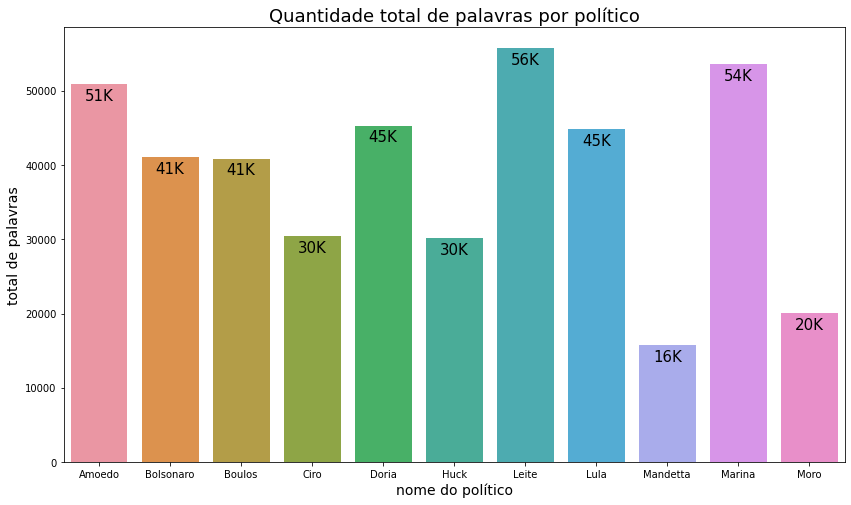

In [63]:
# quantidade de palavras por político

df_plot = df_palavras.groupby('nome').agg(total =('palavra','count'))
df_plot.reset_index(inplace=True)

plt.figure(figsize=(14, 8))
splot=sns.barplot(x="nome", y="total", data=df_plot)
plt.xlabel("nome do político", size=14)
plt.ylabel("total de palavras", size=14)
plt.title("Quantidade total de palavras por político", size=18)
for p in splot.patches:
    splot.annotate(format(round(p.get_height()/1000), '.0f')+"K", 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  size=15,
                  xytext = (0, -12), 
                  textcoords = 'offset points')

### Notamos que os possíveis candidatos Mandetta a Moro possuem menos palavras por terem menos tweets. Mas mesmo entre os com número igual de tweets percebemo que Ciro e Huck devem usar mais palavras de ligação (Stop Words) ou compratilhar links, pois seus números são bem menores que os demais.

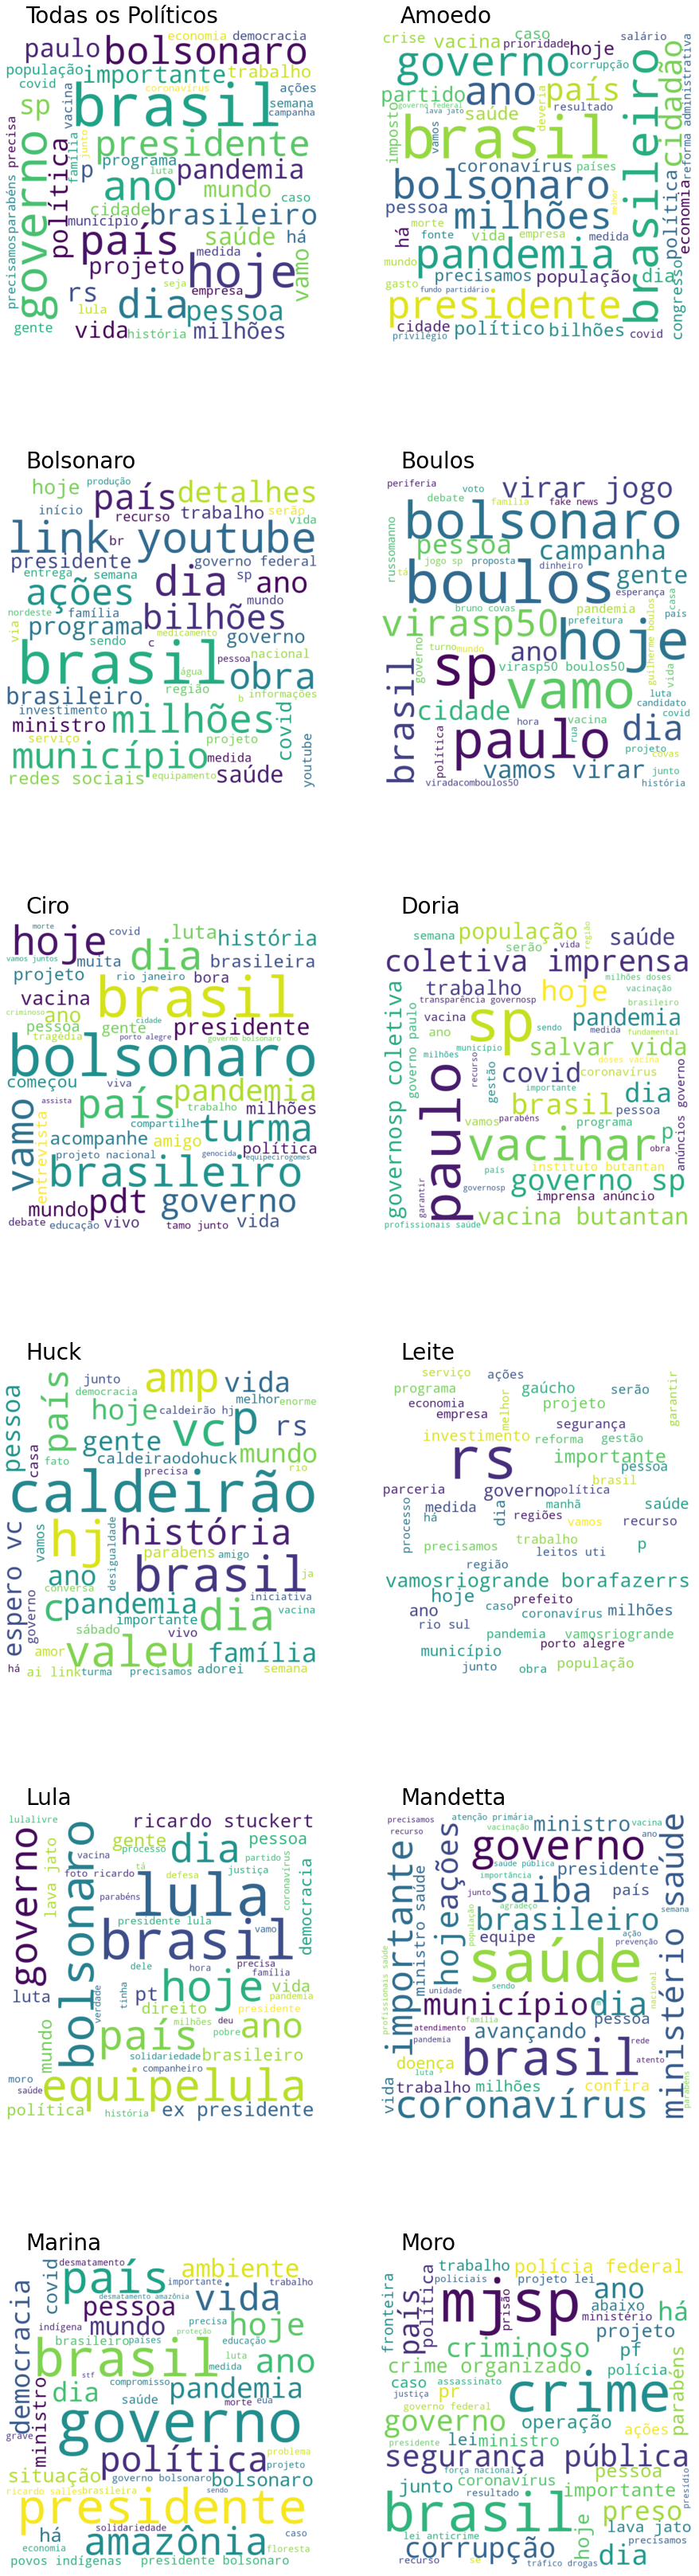

In [73]:
# wordcloud por político
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20, 60), facecolor='w')
xc = 0
yc = 1
sumario = " ".join(s for s in df_palavras['palavra'])
wordcloud = WordCloud(width=800, height=800, max_words=50, max_font_size=150, background_color='white').generate(sumario)
ax[0][0].imshow(wordcloud, interpolation="bilinear")
ax[0][0].text(50, -20, 'Todas os Políticos', fontsize=28, color='k')
ax[0][0].axis('off')

for idx in range(11):
    sumario = " ".join(s for s in df_palavras['palavra'][df_palavras['nome'] == nome_politicos[idx]])
    wordcloud = WordCloud(width=800, height=800, max_words=50, max_font_size=150, 
            background_color='white').generate(sumario)      
    ax[xc][yc].imshow(wordcloud, interpolation="bilinear")
    ax[xc][yc].text(50, -20, nome_politicos[idx], fontsize=28, color='black')
    ax[xc][yc].axis('off')
    yc += 1
    if (yc == 2):
        yc = 0
        xc += 1
        if (xc == 6):
            xc = 0

plt.subplots_adjust(right=0.8, left=0.2, wspace=0.2, hspace=0.2) 
plt.show()

# Análise de frequências

In [74]:
# montando dataframe de frequências

c = Counter(df_palavras['palavra']).most_common()
df_palavras_qtd = pd.DataFrame(c, columns=['palavra', 'qtd'])
for politico in nome_politicos:
    c = Counter(df_palavras['palavra'][df_palavras['nome'] == politico]).most_common()
    d = pd.DataFrame(c, columns=['palavra', politico])
    #d[f'f-{politico}'] = d[politico] / df_palavras_qtd['qtd']
    df_palavras_qtd = pd.merge(df_palavras_qtd, d, on='palavra')

In [76]:
#df_palavras_qtd[df_palavras_qtd['palavra'] == " "]
df_palavras_qtd[:20]

palavra   qtd  Amoedo  Bolsonaro  Boulos  Ciro  Doria  Huck  Leite  \
0        brasil  3492     529        406     211   461    248   226    100   
1       governo  2907     292        240     160   213    470    35    284   
2          hoje  2275     142        116     284   237    319   125    423   
3         saúde  2040     212        152     121   149    337    88    227   
4     bolsonaro  2032     276         77     285   618     39     1      6   
5           dia  1696      87        150     172   194    221   222    141   
6          país  1616     226        137      91   190     70   113     54   
7       milhões  1597     221        279      97   108    278    26    303   
8    presidente  1593     233        167      44    97     68    21     83   
9            sp  1447      33         88     371    11    857    20     17   
10     pandemia  1429     235         54     146   103    284   106    165   
11        vamos  1401     114         20     467   306    130    65    105   
12        paulo  1304      51         46     366    56    577    27     38   
13         anos  1211     150         90     146    74    119    88    142   
14      pessoas  1197     119         85     180    52    139    72    147   
15  coronavírus  1165     172         46      13    24    309    12    199   
16         vida  1148      98         49      81    79    212    99    103   
17    população   945     120         59      61    25    286    21    182   
18           rs   933       4         62      11     7      2   103    731   
19       vacina   879     121         51      82    57    397    32     22   

    Lula  Mandetta  Marina  Moro  
0    483       197     488   143  
1    215       153     715   130  
2    290        70     208    61  
3    104       445     186    19  
4    361        17     340    12  
5    201        90     156    62  
6    246        55     346    88  
7     98        52     116    19  
8    264        55     524    37  
9     22         5      14     9  
10    78        25     214    19  
11    92        31      40    31  
12    76        10      39    18  
13   212        29     114    47  
14   126        40     178    59  
15   103       141      87    59  
16   134        41     238    14  
17    35        57      78    21  
18     2         1       2     8  
19    59        22      30     6

In [77]:
df_palavras_freq = df_palavras_qtd.copy()
for politico in nome_politicos:
     df_palavras_freq[politico] =  df_palavras_qtd[politico]/df_palavras_qtd['qtd']

df_palavras_freq[:20]

palavra   qtd    Amoedo  Bolsonaro    Boulos      Ciro     Doria  \
0        brasil  3492  0.151489   0.116266  0.060424  0.132016  0.071019   
1       governo  2907  0.100447   0.082559  0.055040  0.073271  0.161679   
2          hoje  2275  0.062418   0.050989  0.124835  0.104176  0.140220   
3         saúde  2040  0.103922   0.074510  0.059314  0.073039  0.165196   
4     bolsonaro  2032  0.135827   0.037894  0.140256  0.304134  0.019193   
5           dia  1696  0.051297   0.088443  0.101415  0.114387  0.130307   
6          país  1616  0.139851   0.084777  0.056312  0.117574  0.043317   
7       milhões  1597  0.138384   0.174703  0.060739  0.067627  0.174076   
8    presidente  1593  0.146265   0.104834  0.027621  0.060891  0.042687   
9            sp  1447  0.022806   0.060815  0.256393  0.007602  0.592260   
10     pandemia  1429  0.164451   0.037789  0.102169  0.072078  0.198740   
11        vamos  1401  0.081370   0.014276  0.333333  0.218415  0.092791   
12        paulo  1304  0.039110   0.035276  0.280675  0.042945  0.442485   
13         anos  1211  0.123865   0.074319  0.120562  0.061107  0.098266   
14      pessoas  1197  0.099415   0.071011  0.150376  0.043442  0.116124   
15  coronavírus  1165  0.147639   0.039485  0.011159  0.020601  0.265236   
16         vida  1148  0.085366   0.042683  0.070557  0.068815  0.184669   
17    população   945  0.126984   0.062434  0.064550  0.026455  0.302646   
18           rs   933  0.004287   0.066452  0.011790  0.007503  0.002144   
19       vacina   879  0.137656   0.058020  0.093288  0.064846  0.451650   

        Huck     Leite      Lula  Mandetta    Marina      Moro  
0   0.064719  0.028637  0.138316  0.056415  0.139748  0.040951  
1   0.012040  0.097695  0.073959  0.052632  0.245958  0.044720  
2   0.054945  0.185934  0.127473  0.030769  0.091429  0.026813  
3   0.043137  0.111275  0.050980  0.218137  0.091176  0.009314  
4   0.000492  0.002953  0.177657  0.008366  0.167323  0.005906  
5   0.130896  0.083137  0.118514  0.053066  0.091981  0.036557  
6   0.069926  0.033416  0.152228  0.034035  0.214109  0.054455  
7   0.016281  0.189731  0.061365  0.032561  0.072636  0.011897  
8   0.013183  0.052103  0.165725  0.034526  0.328939  0.023227  
9   0.013822  0.011748  0.015204  0.003455  0.009675  0.006220  
10  0.074178  0.115465  0.054584  0.017495  0.149755  0.013296  
11  0.046395  0.074946  0.065667  0.022127  0.028551  0.022127  
12  0.020706  0.029141  0.058282  0.007669  0.029908  0.013804  
13  0.072667  0.117258  0.175062  0.023947  0.094137  0.038811  
14  0.060150  0.122807  0.105263  0.033417  0.148705  0.049290  
15  0.010300  0.170815  0.088412  0.121030  0.074678  0.050644  
16  0.086237  0.089721  0.116725  0.035714  0.207317  0.012195  
17  0.022222  0.192593  0.037037  0.060317  0.082540  0.022222  
18  0.110397  0.783494  0.002144  0.001072  0.002144  0.008574  
19  0.036405  0.025028  0.067122  0.025028  0.034130  0.006826

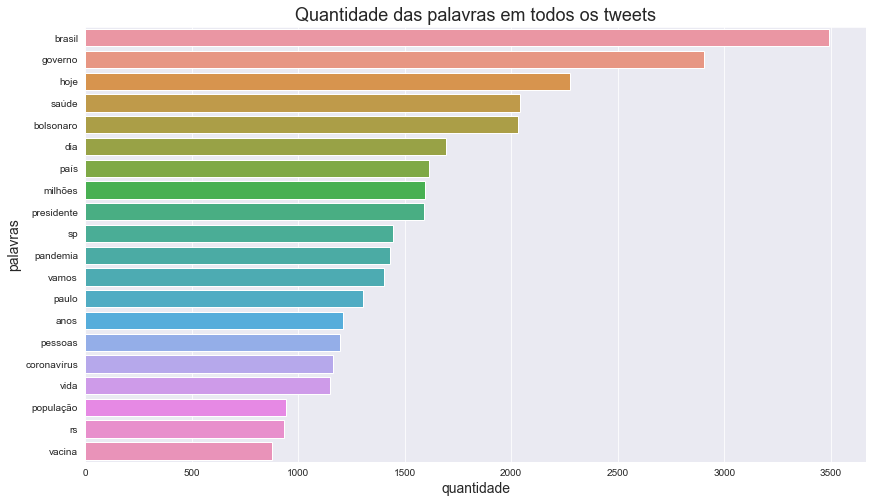

In [79]:
# quantidade de palavras
df_plot = df_palavras_freq[:20]

plt.figure(figsize=(14, 8))
splot=sns.barplot(x="qtd", y="palavra", data=df_plot)
sns.set_style("darkgrid")
plt.xlabel("quantidade", size=14)
plt.ylabel("palavras", size=14)
plt.title("Quantidade das palavras em todos os tweets", size=18)

plt.show()

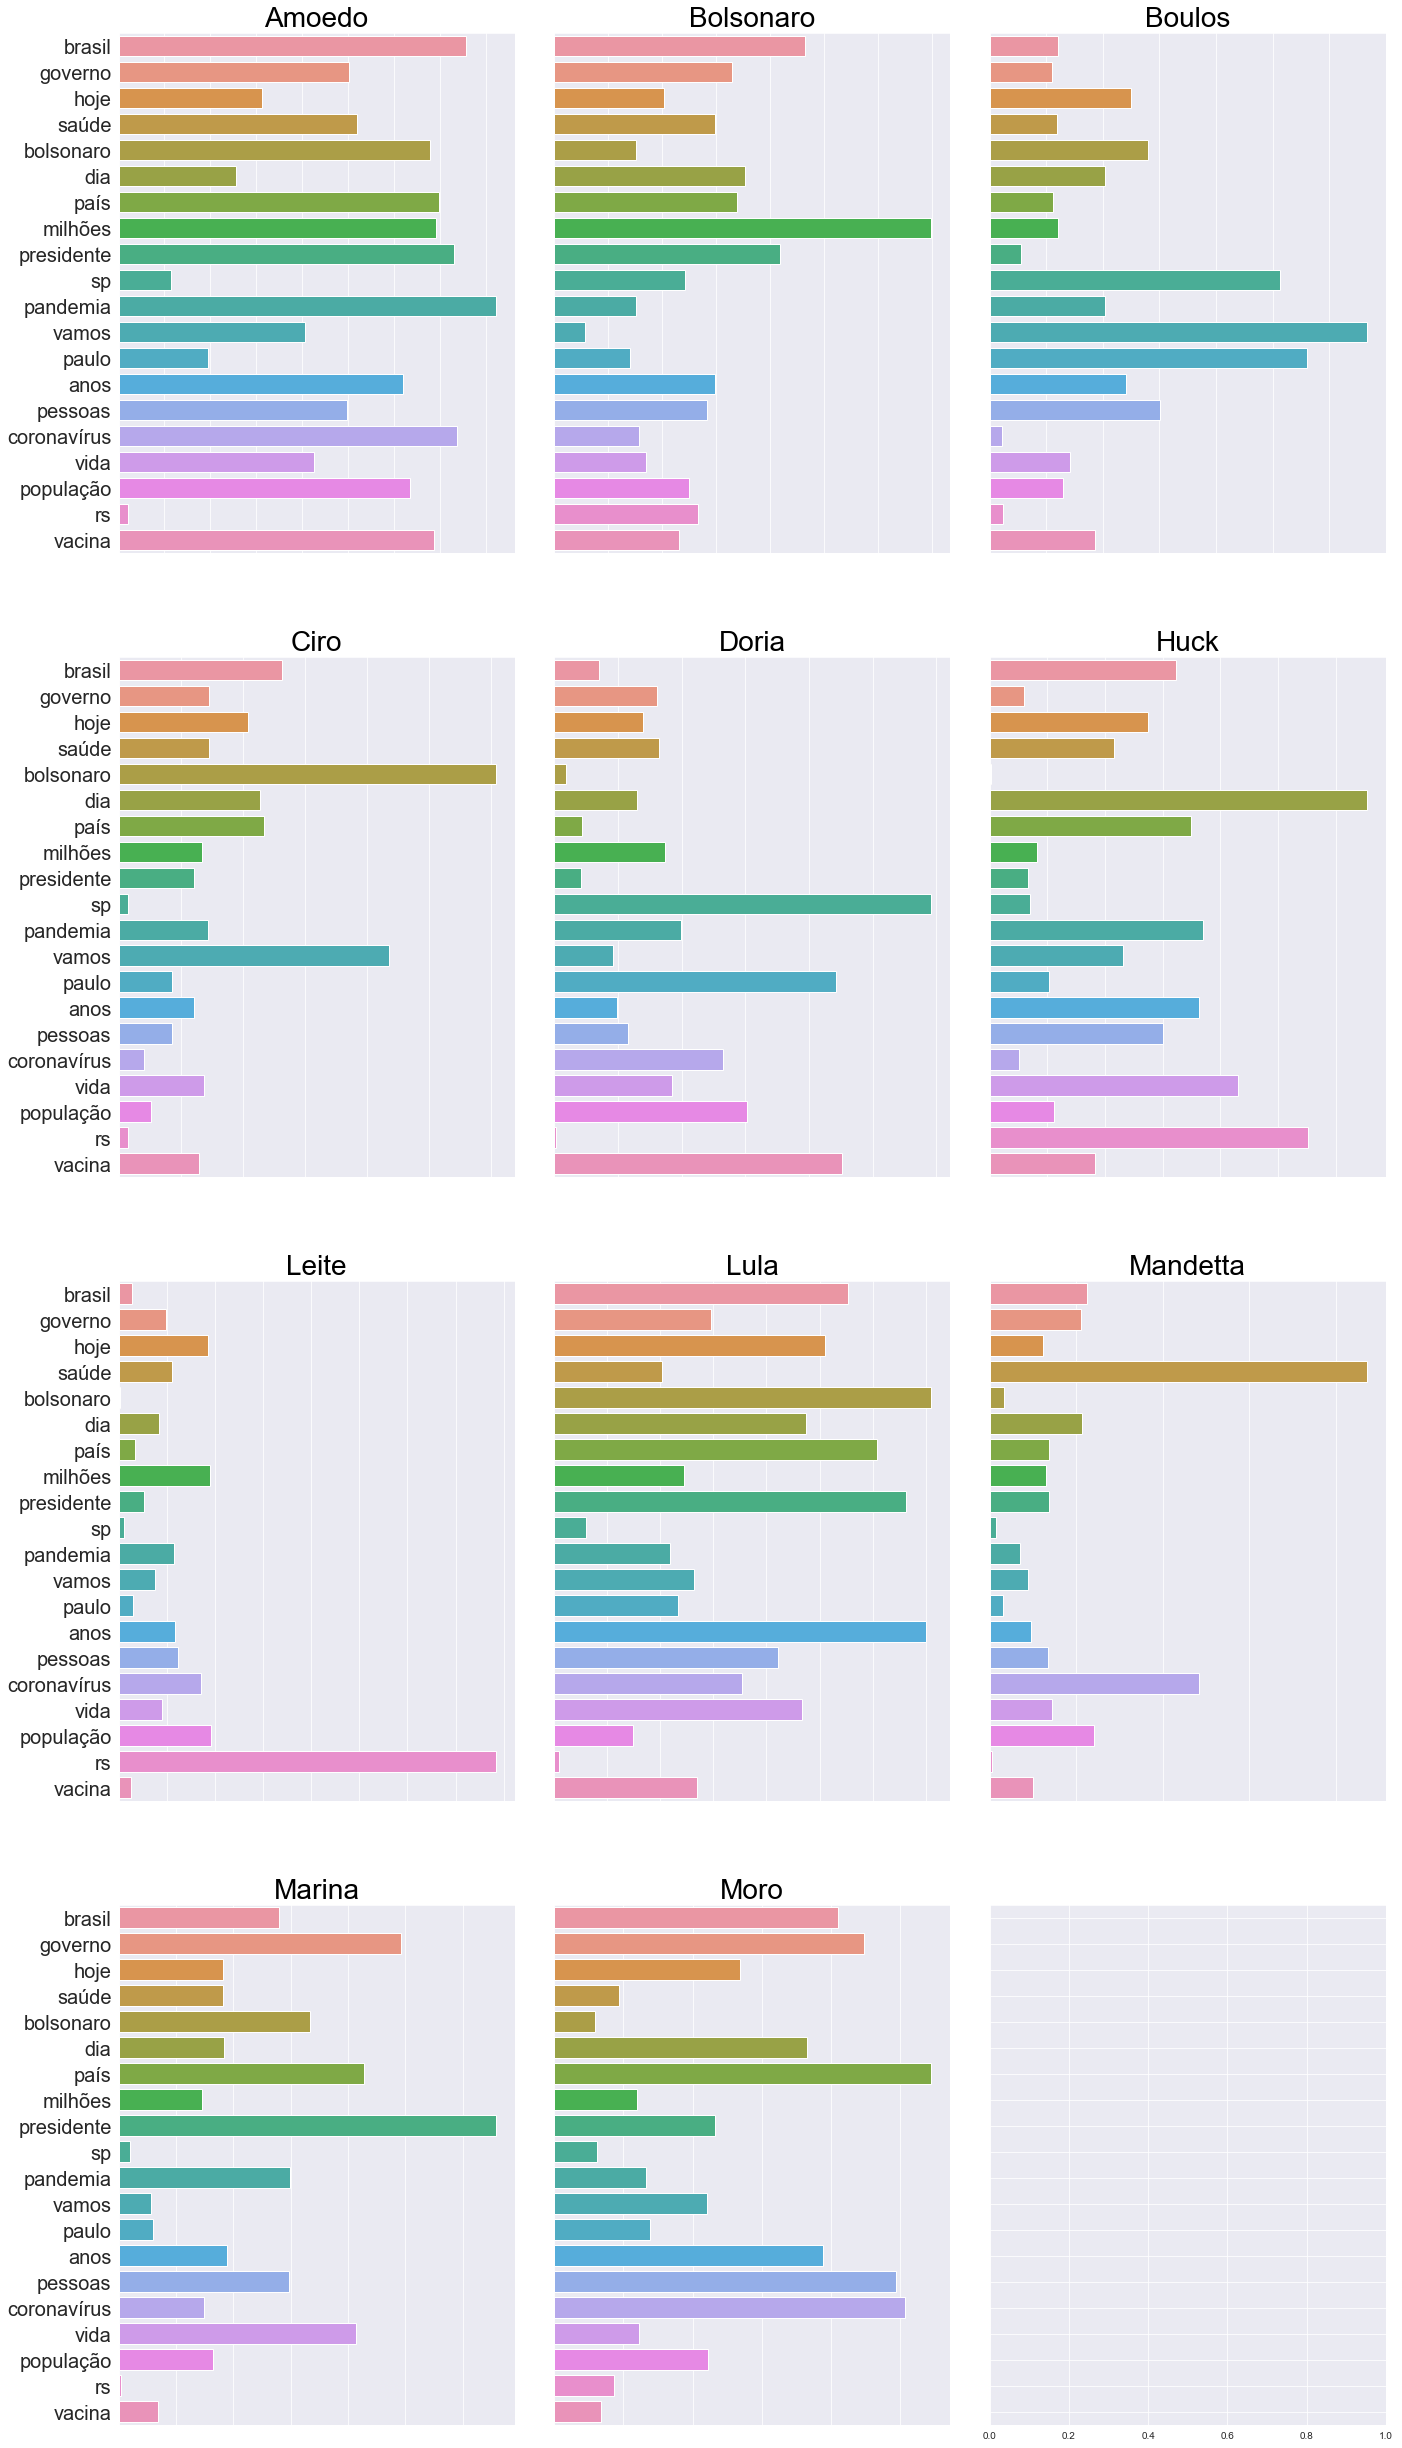

In [86]:
colors = [f'C{x}' for x in range(11)]
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(22, 44), facecolor='w', sharey=True)
xc=0
yc=0
for idx in range(11):
    sns.barplot(y=df_plot['palavra'], x=df_plot[nome_politicos[idx]], ax=ax[xc][yc])
    #ax[xc][yc].barh(y=df_plot['palavra'], width=df_plot[nome_politicos[idx]], height=0.5, color=colors)
    ax[xc][yc].set_title(nome_politicos[idx], fontsize=28, color='black')
    ax[xc][yc].set_ylabel('')
    ax[xc][yc].set_xlabel('')
    ax[xc][yc].tick_params(axis='y', labelsize=20)
    ax[xc][yc].tick_params(axis='x', labelcolor='white')
    yc += 1
    if (yc == 3):
        yc = 0
        xc += 1
        if (xc == 6):
            xc = 0

plt.subplots_adjust(right=0.9, left=0.1, wspace=0.1)
plt.show()